Training: 100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


NameError: name 'generated' is not defined

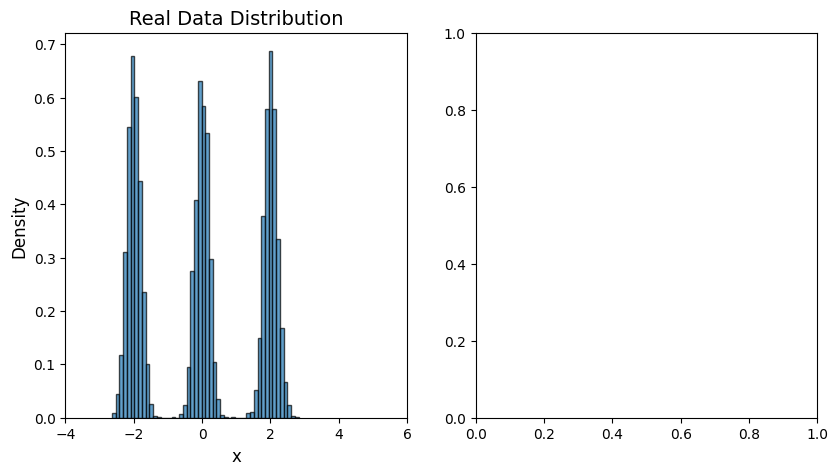

In [1]:
# -*- coding: utf-8 -*-
"""Untitled1.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1OOa7jbRNIoji9R68zY-0rjQatzxX20Yi
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)
n_steps = 1000
beta_start = 0.0001
beta_end = 0.02
batch_size = 256
n_epochs = 100
data_size = 10000
hidden_dim = 64
def get_cosine_schedule(n_steps):
    s = 0.008
    steps = torch.arange(n_steps + 1, dtype=torch.float)
    f_t = torch.cos((steps / n_steps + s) / (1 + s) * torch.pi * 0.5) ** 2
    f_t = f_t / f_t[0]
    betas = torch.clip(1 - f_t[1:] / f_t[:-1], 0.0001, 0.9999)
    return betas

betas = get_cosine_schedule(n_steps)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)


def generate_data(size):
    mix = np.random.choice(3, size=size)
    means = [-2, 0, 2]
    stds = [0.2, 0.2, 0.2]
    data = np.random.normal(loc=[means[i] for i in mix], scale=[stds[i] for i in mix])
    return torch.FloatTensor(data).reshape(-1, 1)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Denoiser(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()

        time_dim = hidden_dim * 4
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(hidden_dim),
            nn.Linear(hidden_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

        self.net = nn.Sequential(
            nn.Linear(1 + time_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.GELU(),
            nn.Linear(hidden_dim * 2, hidden_dim * 2),
            nn.GELU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x, t):
        time_emb = self.time_mlp(t)
        x = torch.cat((x, time_emb), dim=-1)
        return self.net(x)

def diffuse_data(x_0, t):
    noise = torch.randn_like(x_0)
    return (
        sqrt_alphas_cumprod[t].reshape(-1, 1) * x_0 +
        sqrt_one_minus_alphas_cumprod[t].reshape(-1, 1) * noise,
        noise
    )

@torch.no_grad()
def sample(model, n_samples=1000):
    model.eval()
    x = torch.randn(n_samples, 1)

    for t in tqdm(range(n_steps-1, -1, -1), desc='Sampling'):
        t_batch = torch.full((n_samples,), t, dtype=torch.long)
        predicted_noise = model(x, t_batch)

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = 0

        x = 1/torch.sqrt(alphas[t]) * (
            x - betas[t]/sqrt_one_minus_alphas_cumprod[t] * predicted_noise
        ) + torch.sqrt(betas[t]) * noise

    model.train()
    return x

def train_diffusion():
    model = Denoiser(hidden_dim)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs, eta_min=1e-5)

    losses = []

    for epoch in tqdm(range(n_epochs), desc='Training'):
        epoch_losses = []
        for _ in range(100):
            x_0 = generate_data(batch_size)
            t = torch.randint(0, n_steps, (batch_size,))

            x_t, noise = diffuse_data(x_0, t)
            predicted_noise = model(x_t, t)

            loss = nn.HuberLoss()(predicted_noise, noise)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            epoch_losses.append(loss.item())

        scheduler.step()

        if epoch % 10 == 0:
            losses.append(np.mean(epoch_losses))

    return model, losses
model, losses = train_diffusion()



Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 531.58it/s]


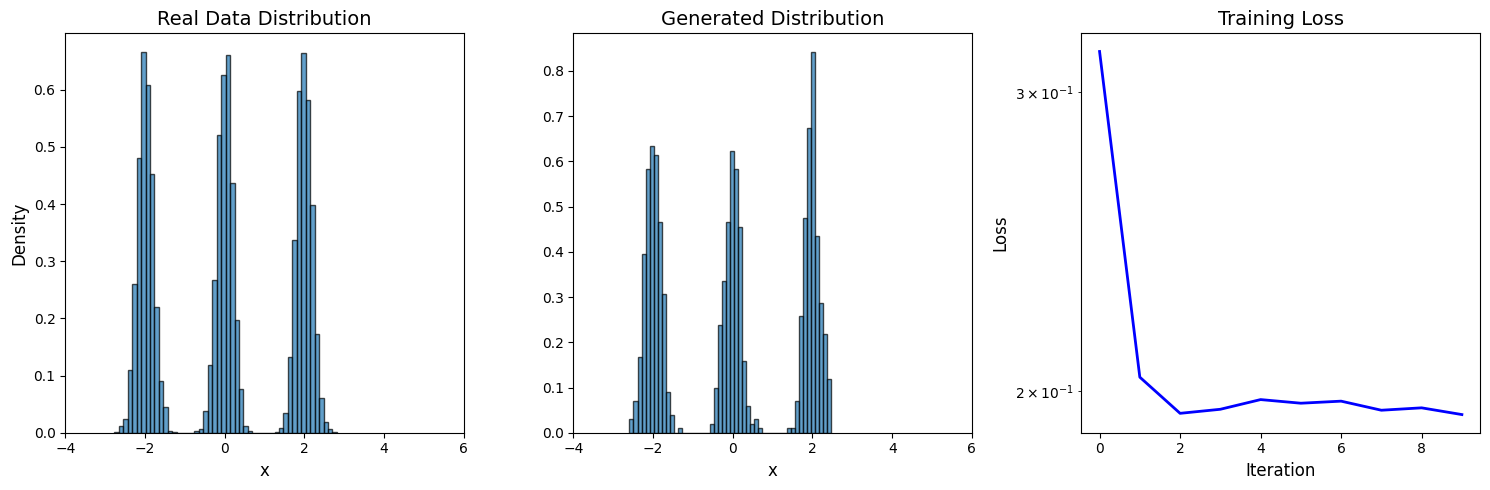

In [4]:

plt.figure(figsize=(15, 5))

plt.subplot(131)
real_data = generate_data(10000).numpy()
plt.hist(real_data, bins=50, density=True, alpha=0.7, edgecolor='black', linewidth=1)
plt.title('Real Data Distribution', fontsize=14)
plt.xlabel('x', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim(-4, 6)

plt.subplot(132)
generated = sample(model, n_samples=1000).numpy()
plt.hist(generated, bins=50, density=True, alpha=0.7, edgecolor='black', linewidth=1)
plt.title('Generated Distribution', fontsize=14)
plt.xlabel('x', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim(-4, 6)


plt.subplot(133)
plt.plot(losses, color='blue', linewidth=2)
plt.title('Training Loss', fontsize=14)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.yscale('log')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

In [5]:
@torch.no_grad()
def sample_dps(model, score_fn, n_samples=1000, guidance_scale=1.0):

    model.eval()
    x = torch.randn(n_samples, 1)

    for t in tqdm(range(n_steps-1, -1, -1), desc='DPS Sampling'):
        t_batch = torch.full((n_samples,), t, dtype=torch.long)

        with torch.enable_grad():

            x = x.detach().requires_grad_(True)
            predicted_noise = model(x, t_batch)
            predicted_x0 = (x - sqrt_one_minus_alphas_cumprod[t] * predicted_noise) / sqrt_alphas_cumprod[t]


            score = score_fn(predicted_x0)


            if not isinstance(score, torch.Tensor):
                score = torch.tensor(score, requires_grad=True)
            if score.ndim > 0:
                score = score.sum()

            grad = torch.autograd.grad(score, x)[0]


        with torch.no_grad():
            predicted_x0 = predicted_x0 + guidance_scale * grad
            x = sqrt_alphas_cumprod[t] * predicted_x0 + sqrt_one_minus_alphas_cumprod[t] * predicted_noise

            if t > 0:
                noise = torch.randn_like(x)
                x = 1/torch.sqrt(alphas[t]) * (
                    x - betas[t]/sqrt_one_minus_alphas_cumprod[t] * predicted_noise
                ) + torch.sqrt(betas[t]) * noise

    model.train()
    return x

def example_score_fn(x):
    return -torch.sum((x)**2)

# Usage example:
samples = sample_dps(model, example_score_fn, n_samples=1000, guidance_scale=0.1)

DPS Sampling: 100%|██████████| 1000/1000 [00:02<00:00, 340.93it/s]


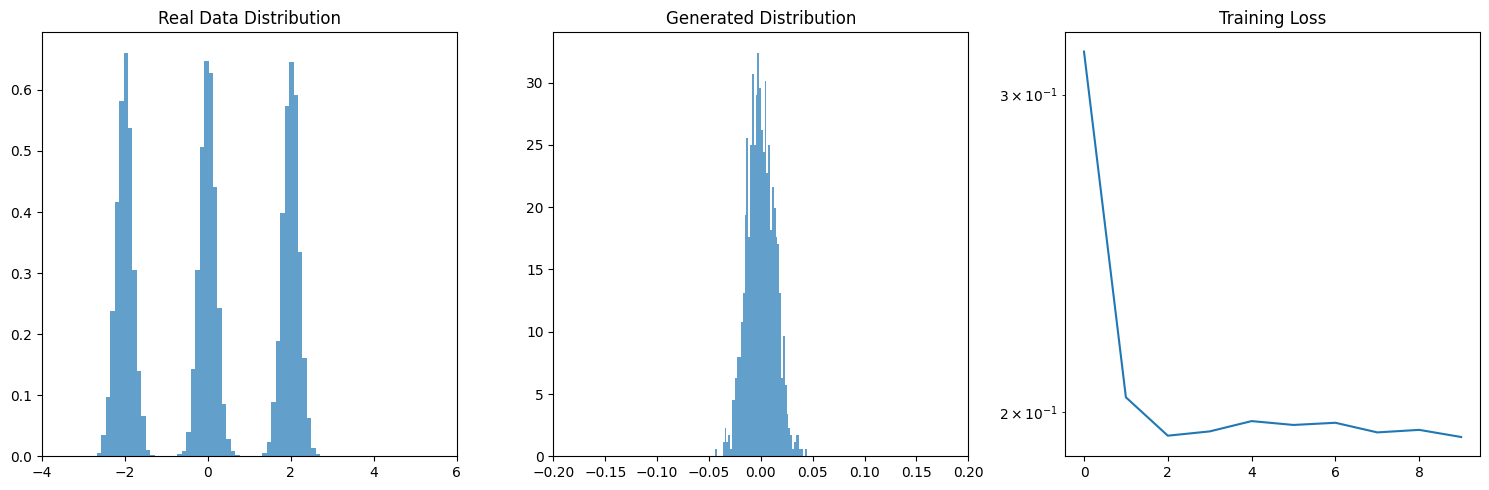

In [6]:

plt.figure(figsize=(15, 5))


plt.subplot(131)
real_data = generate_data(10000).numpy()
plt.hist(real_data, bins=50, density=True, alpha=0.7)
plt.title('Real Data Distribution')
plt.xlim(-4, 6)


plt.subplot(132)
generated = samples.numpy()
plt.hist(generated, bins=50, density=True, alpha=0.7)
plt.title('Generated Distribution')
plt.xlim(-0.2, 0.2)


plt.subplot(133)
plt.plot(losses)
plt.title('Training Loss')
plt.yscale('log')

plt.tight_layout()
plt.show()

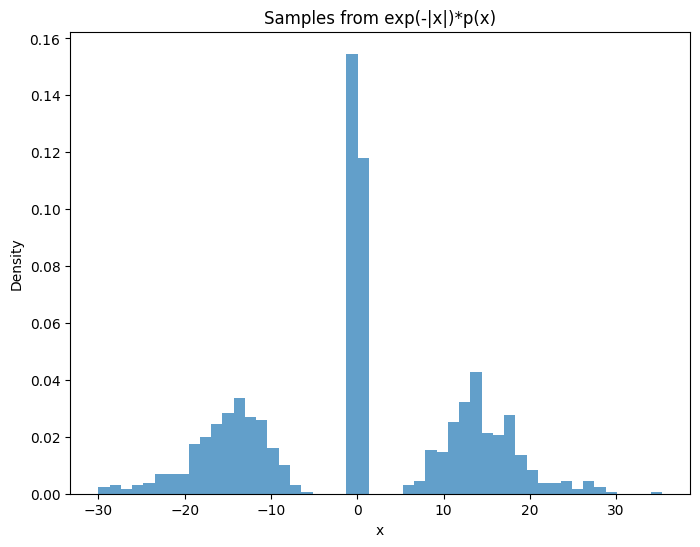

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def generate_data(size):
    mix = np.random.choice(3, size=size)
    means = [-2, 0, 2]
    stds = [0.2, 0.2, 0.2]
    data = np.random.normal(loc=[means[i] for i in mix], scale=[stds[i] for i in mix])
    return torch.FloatTensor(data).reshape(-1, 1)

def sample_from_exp_r_p(n_samples=1000):

    data = generate_data(n_samples)

    samples = data * torch.exp(torch.abs(data))

    return samples

samples = sample_from_exp_r_p(n_samples=1000)

plt.figure(figsize=(8, 6))
plt.hist(samples.numpy(), bins=50, density=True, alpha=0.7)
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Samples from exp(-|x|)*p(x)')
plt.show()

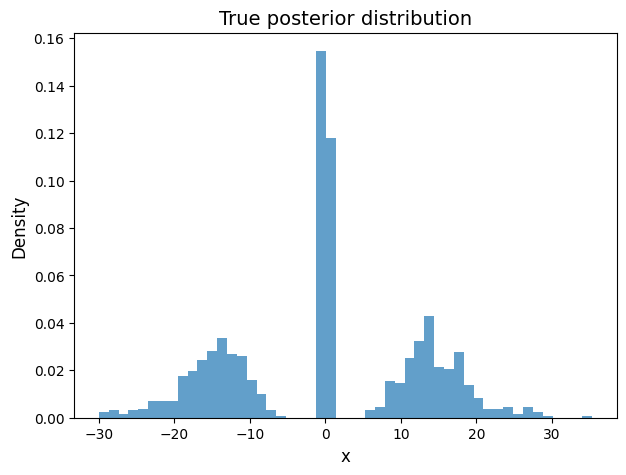

In [2]:
plt.figure(figsize=(7, 5))
generated = samples.numpy()
plt.hist(generated, bins=50, density=True, alpha=0.7)
plt.title('True posterior distribution', fontsize=14)
plt.xlabel('x', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.savefig('true_posterior.pdf', dpi=300)
plt.show()

Generating initial reference samples...


WIND Sampling:   6%|▌         | 59/1000 [00:00<00:01, 585.01it/s]

Resampling reference samples at step 900


WIND Sampling:  18%|█▊        | 178/1000 [00:01<00:08, 100.15it/s]

Resampling reference samples at step 800


WIND Sampling:  27%|██▋       | 266/1000 [00:03<00:10, 73.04it/s]

Resampling reference samples at step 700


WIND Sampling:  39%|███▉      | 391/1000 [00:05<00:06, 87.38it/s]

Resampling reference samples at step 600


WIND Sampling:  49%|████▉     | 488/1000 [00:07<00:07, 68.45it/s]

Resampling reference samples at step 500


WIND Sampling:  58%|█████▊    | 581/1000 [00:09<00:06, 68.34it/s]

Resampling reference samples at step 400


WIND Sampling:  68%|██████▊   | 675/1000 [00:10<00:04, 68.58it/s]

Resampling reference samples at step 300


WIND Sampling:  77%|███████▋  | 771/1000 [00:12<00:03, 69.05it/s]

Resampling reference samples at step 200


WIND Sampling:  86%|████████▋ | 863/1000 [00:14<00:02, 67.66it/s]

Resampling reference samples at step 100


WIND Sampling:  96%|█████████▌| 961/1000 [00:15<00:00, 69.45it/s]

Resampling reference samples at step 0


WIND Sampling: 100%|██████████| 1000/1000 [00:17<00:00, 56.22it/s]


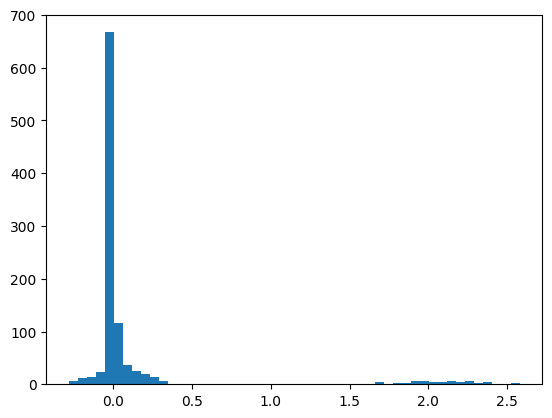

In [8]:
def generate_reference_samples(model, n_reference=10000):
    """Generate independent reference samples for comparison"""
    with torch.no_grad():
        model.eval()
        x = torch.randn(n_reference, 1)

        for t in range(n_steps-1, -1, -1):
            t_batch = torch.full((n_reference,), t, dtype=torch.long)
            predicted_noise = model(x, t_batch)

            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = 0

            x = 1/torch.sqrt(alphas[t]) * (
                x - betas[t]/sqrt_one_minus_alphas_cumprod[t] * predicted_noise
            ) + torch.sqrt(betas[t]) * noise

    return x.detach()


def balanced_wind_sampling(model, n_samples=1000, guidance_scale=0.01, n_reference=1000):
    print("Generating initial reference samples...")
    with torch.no_grad():
        reference_samples = generate_reference_samples(model, n_reference)
    model.eval()
    x = torch.randn(n_samples, 1, requires_grad=True)

    for t in tqdm(range(n_steps-1, -1, -1), desc='WIND Sampling'):
        t_batch = torch.full((n_samples,), t, dtype=torch.long)
        with torch.no_grad():
            predicted_noise = model(x, t_batch)
            predicted_x0 = (x - sqrt_one_minus_alphas_cumprod[t] * predicted_noise) / sqrt_alphas_cumprod[t]


            if (t % 100 == 0) and (t < n_steps - 1):
                print(f"Resampling reference samples at step {t}")
                with torch.no_grad():
                    reference_samples = generate_reference_samples(model, n_reference)


            reference_samples_expanded = reference_samples
            keep_mask = predicted_x0 >= reference_samples_expanded
            x0_updated = torch.where(keep_mask, predicted_x0, torch.zeros_like(predicted_x0))


            x = sqrt_alphas_cumprod[t] * x0_updated + sqrt_one_minus_alphas_cumprod[t] * predicted_noise
            if t > 0:
                noise = torch.randn_like(x)
                x = 1/torch.sqrt(alphas[t]) * (
                    x - betas[t]/sqrt_one_minus_alphas_cumprod[t] * predicted_noise
                ) + torch.sqrt(betas[t]) * noise

    return x

samples = balanced_wind_sampling(model, guidance_scale=0.01)
plt.hist(samples.numpy(), bins=50)
plt.show()

BOND Sampling: 100%|██████████| 1000/1000 [00:03<00:00, 258.41it/s]


Text(0.5, 1.0, 'BOND Sampling (N=2)')

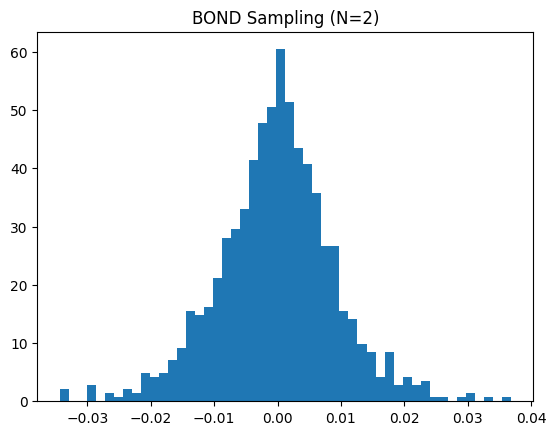

In [9]:
def bond_sampling(model, n_samples=1000, N=1):
    """
    Implements Best-of-N sampling for diffusion models.
    Fixed implementation with proper tensor shapes.
    """
    model.eval()
    x = torch.randn(n_samples, 1)

    for t in tqdm(range(n_steps-1, -1, -1), desc='BOND Sampling'):
        t_batch = torch.full((n_samples,), t, dtype=torch.long)

        with torch.no_grad():

            if t == 999:
              x_candidates = torch.stack([x] * N, dim=1)
              t_candidates = t_batch.unsqueeze(1).expand(-1, N)

            if t > 0:
                noise = torch.randn_like(x_candidates)
            else:
                noise = 0


            predicted_x0_list = []
            predicted_noise_list = []

            for i in range(N):
                curr_x = x_candidates[:, i, :]
                curr_t = t_candidates[:, i]

                curr_noise = model(curr_x, curr_t)
                predicted_noise_list.append(curr_noise)


                curr_x0 = (curr_x - sqrt_one_minus_alphas_cumprod[t] * curr_noise) / \
                         sqrt_alphas_cumprod[t]
                predicted_x0_list.append(curr_x0)


            predicted_x0 = torch.stack(predicted_x0_list, dim=1)
            predicted_noise = torch.stack(predicted_noise_list, dim=1)



            best_indices = (torch.abs(predicted_x0)).argmin(dim=1, keepdim=True)
            x0_updated = torch.gather(predicted_x0, 1, best_indices).squeeze(1)
            update_noise = torch.gather(predicted_noise, 1, best_indices).squeeze(1)


            x = sqrt_alphas_cumprod[t] * x0_updated + sqrt_one_minus_alphas_cumprod[t] * update_noise


            if t > 0:



                x_candidates = torch.stack([x] * N, dim=1)
                noise_candidates = torch.stack([update_noise] * N, dim=1)


                noise = torch.randn_like(x_candidates)
                x_candidates = 1/torch.sqrt(alphas[t]) * (
                    x_candidates - betas[t]/sqrt_one_minus_alphas_cumprod[t] * noise_candidates
                ) + torch.sqrt(betas[t]) * noise



    return x

def compare_sampling_methods(model, n_samples=1000):

    plt.figure(figsize=(15, 5))


    plt.subplot(131)
    with torch.no_grad():
        regular_samples = sample(model, n_samples)
    plt.hist(regular_samples.numpy(), bins=50, density=True)
    plt.title('Regular Sampling')


    plt.subplot(132)
    bond_samples = bond_sampling(model, n_samples, N=10)
    plt.hist(bond_samples.numpy(), bins=50, density=True)
    plt.title('BOND Sampling (N=10)')


    plt.subplot(133)
    wind_samples = balanced_wind_sampling(model, n_samples, guidance_scale=0.01)
    plt.hist(wind_samples.numpy(), bins=50, density=True)
    plt.title('WIND Sampling')

    plt.tight_layout()
    plt.show()

    return regular_samples, bond_samples, wind_samples


bond_samples = bond_sampling(model, n_samples=1000, N=2)
plt.hist(bond_samples.numpy(), bins=50, density=True)
plt.title('BOND Sampling (N=2)')

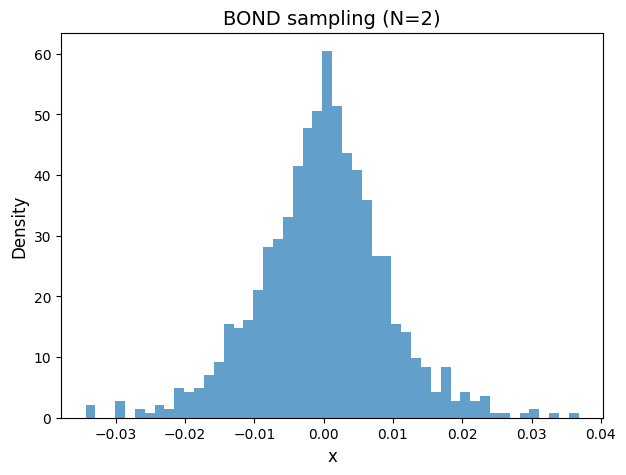

In [10]:
plt.figure(figsize=(7, 5))
generated = bond_samples.numpy()
plt.hist(generated, bins=50, density=True, alpha=0.7)
plt.title('BOND sampling (N=2)', fontsize=14)
plt.xlabel('x', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.savefig('generated_distribution_bond.pdf', dpi=300)
plt.show()  # Close the figure